In [1]:
! pip install btester requests tqdm yfinance quantstats==0.0.59

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import yfinance as yf
import pandas as pd
import requests

start = '2006-01-01'
end = '2024-01-01'

assets = 'nasdaq100'
benchmark = 'NQ=F'

ldf = pd.read_html(requests.get(f'https://www.slickcharts.com/{assets}', headers={'User-agent': 'Mozilla/5.0'}).text)
symbols = [x.replace('.','-') for x in ldf[0]['Symbol'] if isinstance(x, str)]
downloads = yf.download([*symbols, benchmark], start, end, group_by='ticker')

data = downloads[symbols]
benchmark = downloads[benchmark]['Close']

[*********************100%%**********************]  102 of 102 completed


In [3]:
from btester import Strategy

def EMA(ser: pd.Series, period: int):
    return ser.ewm(span=period, adjust=False).mean().values

class MACrossoverStrategy(Strategy):
    buy_at_once_size = .01 # 1%

    def init(self, fast_period: int, slow_period: int):
        self.fast_ma = {}
        self.slow_ma = {}

        for symbol in self.symbols:
            self.fast_ma[symbol] = EMA(self.data[(symbol,'Close')], fast_period)
            self.slow_ma[symbol] = EMA(self.data[(symbol,'Close')], slow_period)

    def next(self, i, record):
        for symbol in self.symbols:
            if self.fast_ma[symbol][i-1] > self.slow_ma[symbol][i-1]:
                self.open(symbol=symbol, price=record[(symbol,'Open')], size=self.positionSize(record[(symbol,'Open')]))

        for position in self.open_positions[:]:
            if self.fast_ma[position.symbol][i-1] < self.slow_ma[position.symbol][i-1]:
                self.close(position=position, price=record[(position.symbol,'Open')])

    def positionSize(self, price: float):
        return round((self.cash + self.assets_value) / price * self.buy_at_once_size) if price > 0 else 0

In [4]:
from btester import Backtest
backtest = Backtest(MACrossoverStrategy, data, commission=.001, cash=1e6)

In [5]:
import quantstats as qs
from itertools import product
from tqdm.contrib.concurrent import process_map

parameters = ['Fast MA','Slow MA']
values = [[5, 10, 15, 20, 25], [30, 35, 40, 45, 50]]

def run(v):
    result = backtest.run(*v)
    returns = result.returns
    return [*v, returns.iloc[0], returns.iloc[-1], qs.stats.max_drawdown(returns) * 100, qs.stats.cagr(returns) * 100, qs.stats.sharpe(returns)]

optimization_results = process_map(run, list(product(*values)))
optimization_results = pd.DataFrame(optimization_results, columns=[*parameters,'Initial Capital','Cumulative Return','Max Drawdown (%)','CAGR (%)','Sharpe Ratio'])
optimization_results.set_index([*parameters], inplace=True)

100%|██████████| 25/25 [00:09<00:00,  2.52it/s]


In [6]:
optimization_results_sorted = optimization_results.sort_values('Sharpe Ratio', ascending=False)
optimization_results_sorted

Initial Capital  Cumulative Return  Max Drawdown (%)  \
Fast MA Slow MA                                                         
25      45          1.004972e+06       6.340532e+07        -41.501545   
        50          1.005008e+06       5.935939e+07        -45.237440   
20      50          1.004972e+06       5.084614e+07        -39.885080   
25      40          1.004972e+06       5.242237e+07        -39.746374   
15      40          1.005513e+06       4.522073e+07        -41.118211   
        30          1.005513e+06       4.236967e+07        -40.402558   
        45          1.005062e+06       4.349430e+07        -40.296882   
25      35          1.004972e+06       4.196322e+07        -38.024667   
15      35          1.005513e+06       3.898596e+07        -42.163779   
20      30          1.005513e+06       3.984206e+07        -41.439485   
15      50          1.005062e+06       4.139080e+07        -39.442412   
20      35          1.004973e+06       3.980472e+07        -41.257851   
10      40          1.005513e+06       3.753906e+07        -42.432302   
20      45          1.004972e+06       4.054256e+07        -40.028368   
10      50          1.005602e+06       3.637331e+07        -42.742214   
5       35          1.005510e+06       3.254845e+07        -46.040229   
10      45          1.005602e+06       3.422151e+07        -42.653282   
25      30          1.004973e+06       3.689045e+07        -38.286008   
20      40          1.005062e+06       3.857769e+07        -38.147412   
5       30          1.005164e+06       3.005789e+07        -49.231094   
        50          1.005578e+06       2.873963e+07        -41.851825   
10      35          1.005642e+06       2.880855e+07        -42.458667   
5       40          1.005599e+06       2.559999e+07        -43.152430   
        45          1.005599e+06       2.437980e+07        -43.978764   
10      30          1.005510e+06       2.338436e+07        -45.335392   

                  CAGR (%)  Sharpe Ratio  
Fast MA Slow MA                           
25      45       25.896500      1.123269  
        50       25.435837      1.092162  
20      50       24.361761      1.080720  
25      40       24.572897      1.080199  
15      40       23.550508      1.063784  
        30       23.104250      1.054212  
        45       23.286643      1.044454  
25      35       23.042013      1.040555  
15      35       22.536250      1.035220  
20      30       22.684233      1.034780  
15      50       22.947533      1.031830  
20      35       22.681499      1.030159  
10      40       22.279021      1.027641  
20      45       22.806773      1.027103  
10      50       22.064268      1.017598  
5       35       21.313649      1.015061  
10      45       21.651373      1.014967  
25      30       22.164300      1.014697  
20      40       22.467642      1.013971  
5       30       20.780550      1.010227  
        50       20.477194      0.970472  
10      35       20.492800      0.965990  
5       40       19.705121      0.953918  
        45       19.380731      0.934793  
10      30       19.105111      0.918497

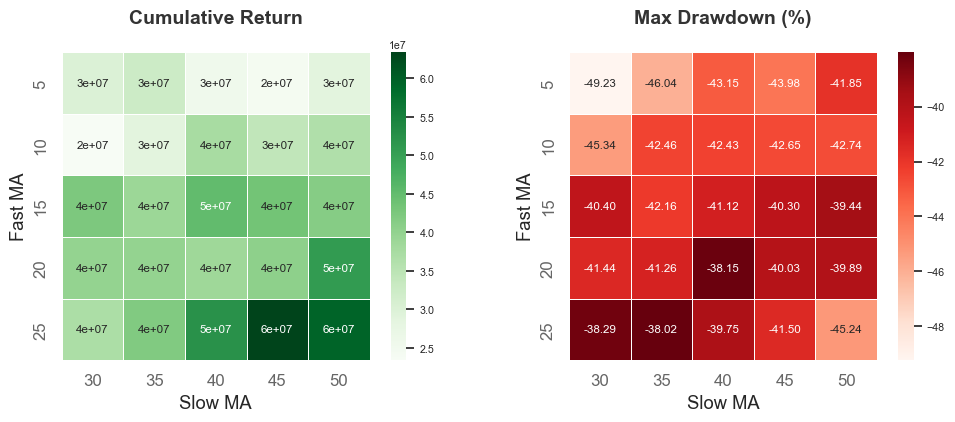

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(1, 2, figsize=(12,4))

ax[0].set_title('Cumulative Return\n', fontsize=14, fontweight='bold')
ax[1].set_title('Max Drawdown (%)\n', fontsize=14, fontweight='bold')

reshape = lambda d: pd.DataFrame(d.values.reshape(len(d.index.levels[0]), len(d.index.levels[1])), d.index.levels[0], d.index.levels[1])

sns.set(font_scale=.7)
sns.heatmap(reshape(optimization_results['Cumulative Return']), ax=ax[0], annot=True, fmt='.0g', linewidth=.5, square=True, cmap='Greens')
sns.heatmap(reshape(optimization_results['Max Drawdown (%)']), ax=ax[1], annot=True, fmt='.2f', linewidth=.5, square=True, cmap='Reds')

plt.show()

In [8]:
best_params = optimization_results_sorted.index[0]
best_params

(25, 45)

In [9]:
result = backtest.run(*best_params)

In [10]:
import quantstats as qs
qs.reports.metrics(result.returns, benchmark)

                    Strategy    Benchmark
------------------  ----------  -----------
Start Period        2006-01-03  2006-01-03
End Period          2023-12-29  2023-12-29
Risk-Free Rate      0.0%        0.0%
Time in Market      100.0%      100.0%

Cumulative Return   6,209.16%   905.52%
CAGR﹪              25.9%       13.68%

Sharpe              1.12        0.69
Prob. Sharpe Ratio  100.0%      99.82%
Sortino             1.62        0.97
Sortino/√2          1.14        0.69
Omega               1.22        1.22

Max Drawdown        -41.5%      -53.85%
Longest DD Days     840         1161

Gain/Pain Ratio     0.22        0.14
Gain/Pain (1M)      1.57        0.83

Payoff Ratio        0.94        0.86
Profit Factor       1.22        1.14
Common Sense Ratio  1.18        1.04
CPC Index           0.64        0.54
Tail Ratio          0.97        0.92
Outlier Win Ratio   3.73        4.18
Outlier Loss Ratio  3.75        4.0

MTD                 5.98%       6.49%
3M                  13.71%      14

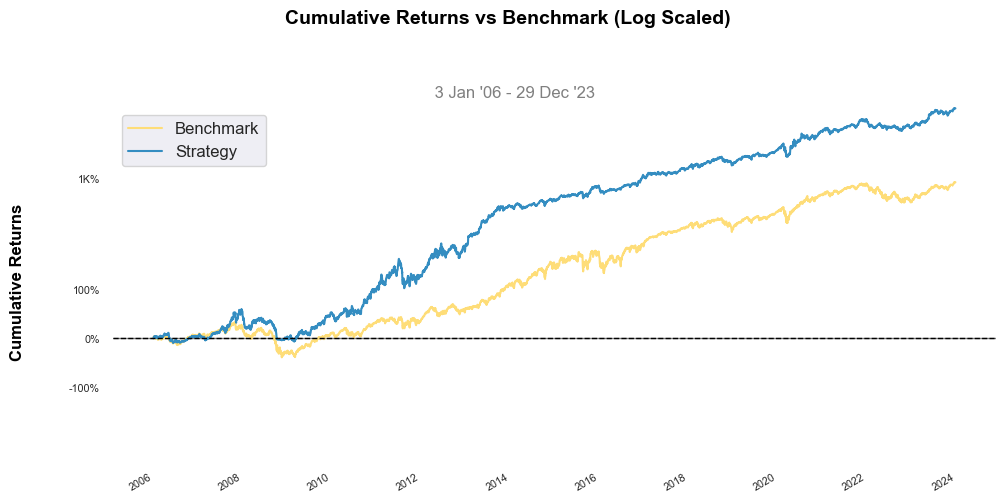

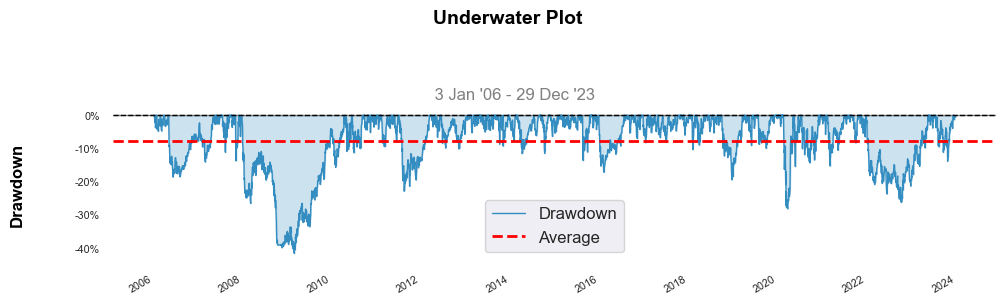

In [11]:
qs.plots.log_returns(result.returns, benchmark, fontname='sans-serif')
qs.plots.drawdown(result.returns, figsize=(10,3), fontname='sans-serif')

In [14]:
trades = pd.DataFrame(result.trades)
trades

,symbol,open_date,close_date,open_price,close_price,position_size,profit_loss,change_pct,trade_commission,cumulative_return
0,AMZN,2006-01-03,2006-01-05,2.373500,2.358000,4213,-65.301789,-0.653047,19.933810,9.999148e+05
1,ADBE,2006-01-03,2006-01-05,37.200001,38.259998,269,285.139343,2.849456,20.298740,1.000180e+06
2,PEP,2006-01-03,2006-01-05,59.919998,59.610001,167,-51.769592,-0.517352,19.961510,1.000108e+06
3,NFLX,2006-01-03,2006-01-05,3.865714,3.552857,2587,-809.361450,-8.093127,19.191843,9.992793e+05
4,AMGN,2006-01-03,2006-01-05,79.360001,79.910004,126,69.300385,0.693048,20.068021,9.993286e+05
...,...,...,...,...,...,...,...,...,...,...
5754,GILD,2023-11-02,2023-11-17,79.809998,74.889999,6851,-33706.907455,-6.164639,1059.849679,5.053664e+07
5755,VRTX,2023-08-21,2023-11-29,344.769989,347.500000,1605,4381.667633,0.791835,1111.093332,5.053991e+07
5756,VRTX,2023-09-27,2023-11-29,351.160004,347.500000,1560,-5709.605713,-1.042261,1089.909606,5.053311e+07
5757,VRTX,2023-10-03,2023-11-29,345.279999,347.500000,1636,3631.921997,0.642957,1133.388078,5.053560e+07


In [13]:
open_positions = pd.DataFrame(result.open_positions)
open_positions

,symbol,open_date,last_date,open_price,last_price,position_size,profit_loss,change_pct,current_value
0,SNPS,2022-12-28,2023-12-29,317.820007,514.909973,1211,238675.948608,62.013077,6.235560e+05
1,META,2023-01-11,2023-12-29,130.960007,353.959991,3097,690630.952744,170.280981,1.096214e+06
2,META,2023-01-19,2023-12-29,132.490005,353.959991,3047,674819.047226,167.159768,1.078516e+06
3,META,2023-01-30,2023-12-29,149.410004,353.959991,2855,583990.215149,136.905149,1.010556e+06
4,META,2023-03-02,2023-12-29,172.380005,353.959991,2395,434884.067841,105.337035,8.477342e+05
...,...,...,...,...,...,...,...,...,...
88,AAPL,2023-11-20,2023-12-29,189.889999,192.529999,3090,8157.598114,1.390278,5.949177e+05
89,AAPL,2023-11-30,2023-12-29,189.839996,192.529999,3160,8500.407715,1.416984,6.083948e+05
90,MSFT,2023-11-30,2023-12-29,378.489990,376.040009,1585,-3883.220978,-0.647304,5.960234e+05
91,AMZN,2023-11-30,2023-12-29,144.759995,151.940002,4144,29753.952881,4.959939,6.296394e+05
